In [361]:
import torch
import matplotlib.pyplot as plt
import numpy as np

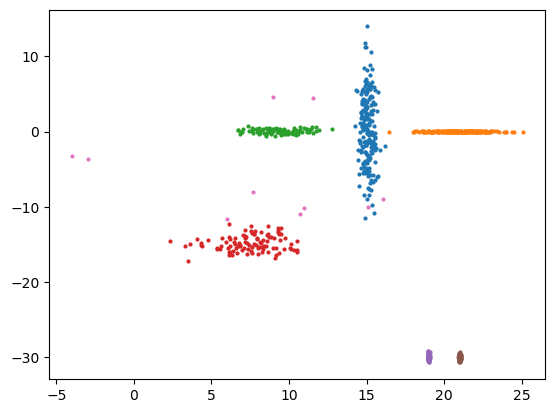

In [510]:
mus = [[15., 0.], [21., 0.], [9.3, 0.], [7.5, -15.], [19, -30.], [21, -30.], [13, -5.]]
sigs = [[0.1, 20], [2, 0.001], [1.5, 0.1], [3, 1.], [0.001, 0.1], [0.001, 0.1], [100, 100.]]
Ns = [200, 200, 100, 100, 100, 100, 10]

pts = []
for i in range(len(Ns)):
    sampler = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.tensor(mus[i]), covariance_matrix=torch.diag(torch.tensor(sigs[i])))
    pts.append(np.asarray([sampler.sample().tolist() for _ in range(Ns[i])]))
for p in pts:
    plt.scatter(p[:, 0], p[:, 1], s=4)